Step-by-Step: Correlation Visualization

 Hypothesis Testing with Your IMDb Data

𝐻 0 H 0​: There is no difference in average ratings between movies with the target genre and those without.

𝐻 𝐴 H A​: There is a significant difference in average ratings.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


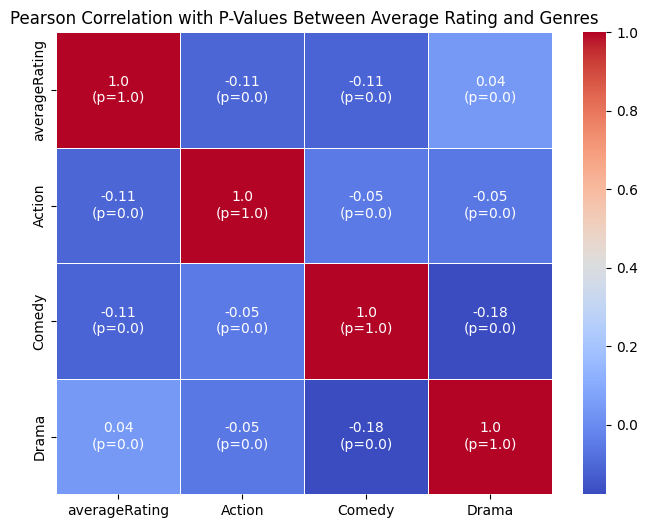

T-statistic: -60.69419928142061
P-value: 0.0
Reject the null hypothesis: There is a significant difference in average ratings.


In [6]:
# Step-by-Step: Correlation Visualization and Hypothesis Testing with IMDb Data

import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
import gzip
import shutil
import zipfile

# Mount Google Drive
drive.mount('/content/drive')

# Define paths for unzipping
base_path = '/content/drive/MyDrive/'  # Adjust if your files are in a subfolder

# Unzip title.basics.tsv.gz
with gzip.open(base_path + 'title.basics.tsv.gz', 'rb') as f_in:
    with open('/content/title.basics.tsv', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

# Unzip title.ratings.tsv.gz
with gzip.open(base_path + 'title.ratings.tsv.gz', 'rb') as f_in:
    with open('/content/title.ratings.tsv', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

# Unzip rotten_tomatoes_critic_reviews.csv.zip
with zipfile.ZipFile(base_path + 'rotten_tomatoes_critic_reviews.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

# Load the datasets
df_basics = pd.read_csv('/content/title.basics.tsv', sep='\t', dtype=str)
df_ratings = pd.read_csv('/content/title.ratings.tsv', sep='\t', dtype=str)
df_reviews = pd.read_csv('/content/rotten_tomatoes_critic_reviews.csv')

# Filter for movies (excluding TV shows and adult content)
df_basics = df_basics[(df_basics['titleType'] == 'movie') & (df_basics['isAdult'] == '0')]

# Merge with ratings data
df = pd.merge(df_basics[['tconst', 'primaryTitle', 'genres']], df_ratings[['tconst', 'averageRating']], on='tconst')

# Convert ratings to numeric
df['averageRating'] = pd.to_numeric(df['averageRating'], errors='coerce')

# Drop rows with missing ratings
df = df.dropna(subset=['averageRating'])

# Create binary genre columns for the genres we are interested in (e.g., 'Action', 'Comedy', 'Drama')
for genre in df['genres'].str.split(',', expand=True).stack().unique():
    df[genre] = df['genres'].str.contains(genre, case=False, na=False, regex=False).astype(int)

# Select relevant columns for correlation analysis
genres = ['Action', 'Comedy', 'Drama']  # Add more genres as needed
data = df[['averageRating'] + genres]

# Compute correlations and p-values using Pearson correlation
def corr_with_pvalues(df):
    cols = df.columns
    corr = df.corr()
    pvals = pd.DataFrame(np.ones((len(cols), len(cols))), columns=cols, index=cols)

    for i in range(len(cols)):
        for j in range(len(cols)):
            if i != j:
                r, p = stats.pearsonr(df[cols[i]], df[cols[j]])
                pvals.iloc[i, j] = p
    return corr, pvals

# Calculate correlation and p-value matrices
corr_matrix, pval_matrix = corr_with_pvalues(data)

# Annotate correlation matrix with p-values
annot = corr_matrix.round(2).astype(str) + "\n(p=" + pval_matrix.round(3).astype(str) + ")"

# Plot the correlation heatmap with annotated p-values
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=annot, fmt='', cmap='coolwarm', linewidths=0.5)
plt.title('Pearson Correlation with P-Values Between Average Rating and Genres')
plt.show()

# Hypothesis testing: Null and Alternative Hypothesis
# H₀: There is no difference in average ratings between movies with the target genre and those without.
# H₁: There is a significant difference in average ratings.

# Perform hypothesis testing for a specific genre (e.g., 'Action')
target_genre = 'Action'

# Create a binary column indicating whether a movie belongs to the 'Action' genre
df['is_action'] = df[target_genre]

# Perform a t-test comparing ratings between movies with the 'Action' genre and those without
action_movies = df[df['is_action'] == 1]['averageRating']
non_action_movies = df[df['is_action'] == 0]['averageRating']

# Two-sample t-test
t_stat, p_val = stats.ttest_ind(action_movies, non_action_movies)

# Display the t-statistic and p-value
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_val}")

# Decision based on p-value
alpha = 0.05
if p_val < alpha:
    print("Reject the null hypothesis: There is a significant difference in average ratings.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in average ratings.")
